In [163]:
from typing import List
from Matrix import Matrix

def gauss_solver(A: 'Matrix', b: 'Matrix') -> List['Matrix']:
    n = A.n
    # формируем расширенную матрицу
    augmented = [A[i] + b[i] for i in range(n)]
    
    # прямой ход
    for i in range(n):
        # поиск главного элемента
        max_row = max(range(i, n), key=lambda r: abs(augmented[r][i]))
        if abs(augmented[max_row][i]) < 1e-12:
            raise ValueError("Система несовместна или имеет бесконечно много решений")
        
        augmented[i], augmented[max_row] = augmented[max_row], augmented[i]
        
        # приведение к ступенчатому виду
        for j in range(i+1, n):
            ratio = augmented[j][i] / augmented[i][i]
            for k in range(i, n+1):
                augmented[j][k] -= ratio * augmented[i][k]
    
    # обратный ход
    x = [0] * n
    for i in range(n-1, -1, -1):
        x[i] = (augmented[i][-1] - sum(augmented[i][j] * x[j] for j in range(i+1, n))) / augmented[i][i]

    # возвращаю решение как список из одной Matrix
    return [Matrix([[val] for val in x])]


In [164]:
 def center_data(X: 'Matrix')-> 'Matrix':
    n, m = X.shape()
    
    # вычисляю среднее значение по каждому столбцу
    means = [sum(X[i][j] for i in range(n)) / n for j in range(m)]
    
    #вычитаю среднее значение из каждого элемента столбца
    X_centered = [
        [X[i][j] - means[j] for j in range(m)] for i in range(n)]
    
    return Matrix(X_centered)

In [165]:
 def covariance_matrix(X_centered: 'Matrix')-> 'Matrix':
    n, m = X_centered.shape()
    #нахожу XTX
    res = X_centered.transpose() @ X_centered
    #делю каждый элемент на n-1
    cov_matrix = [[elem / (n - 1) for elem in row] for row in res.data]

    return Matrix(cov_matrix)

In [166]:
import math
def find_eigenvalues(C: 'Matrix', tol: float = 1e-6) -> List[float]:
    n, _ = C.shape()

    def determinant(lam: float) -> float:
        # C - λI
        C_lambda = [row.copy() for row in C.data]
        for i in range(n):
            C_lambda[i][i] -= lam
        
        # гауссово исключение только на матрице, без b
        sign = 1
        for i in range(n):
            # Поиск ведущего элемента
            max_row = max(range(i, n), key=lambda r: abs(C_lambda[r][i]))
            if abs(C_lambda[max_row][i]) < 1e-12:
                return 0.0
            if max_row != i:
                C_lambda[i], C_lambda[max_row] = C_lambda[max_row], C_lambda[i]
                sign *= -1
            for j in range(i+1, n):
                ratio = C_lambda[j][i] / C_lambda[i][i]
                for k in range(i, n):
                    C_lambda[j][k] -= ratio * C_lambda[i][k]

        det = sign
        for i in range(n):
            det *= C_lambda[i][i]
        return det

    # норма Фробениуса как граница
    frob_norm = math.sqrt(sum(C[i][j]**2 for i in range(n) for j in range(n)))
    L = frob_norm + 1
    a, b = -L, L
    step = tol * 10

    # точное количество знаков
    decimal_places = 0
    t = tol
    while t < 1:
        t *= 10
        decimal_places += 1

    eigenvalues = []
    x = a
    prev_f = determinant(x)
    while x < b:
        x_next = x + step
        f_next = determinant(x_next)

        if prev_f * f_next < 0:
            # бисекция
            left, right = x, x_next
            f_left = prev_f
            while right - left > tol:
                mid = (left + right) / 2
                f_mid = determinant(mid)
                if f_left * f_mid < 0:
                    right = mid
                else:
                    left = mid
                    f_left = f_mid
            root = round((left + right) / 2, decimal_places)
            if all(abs(root - ev) > tol for ev in eigenvalues):  # уникальность
                eigenvalues.append(root)

        prev_f = f_next
        x = x_next

    return sorted(eigenvalues)

In [167]:
def find_eigenvectors(C: Matrix, eigenvalues: List[float], tol: float = 1e-6) -> List[Matrix]:
    n, _ = C.shape()
    eigenvectors = []

    for lam in eigenvalues:
        # создаю матрицу (C - λI)
        A = [row.copy() for row in C.data]
        for i in range(n):
            A[i][i] -= lam

        # прямой ход метода Гаусса
        pivots = []
        for i in range(n):
            # поиск ведущего элемента с использованием 
            pivot = next((r for r in range(i, n) if abs(A[r][i]) > tol), None)
            if pivot is None:
                continue

            A[i], A[pivot] = A[pivot], A[i]
            pivots.append(i)

            # нормализация и обнуление столбца
            pivot_val = A[i][i]
            A[i] = [x / pivot_val for x in A[i]]
            for r in range(n):
                if r != i and abs(A[r][i]) > tol:
                    factor = A[r][i]
                    A[r] = [x - factor * A[i][j] for j, x in enumerate(A[r])]

        # генерация базиса 
        free_vars = [j for j in range(n) if j not in pivots]
        for f in free_vars:
            vec = [0.0] * n
            vec[f] = 1.0
            # обратный ход для зависимых переменных
            for i in reversed(pivots):
                row = A[i]
                vec[i] = -sum(row[j] * vec[j] for j in range(n) if j != i) / row[i]
            
            eigenvectors.append(Matrix([[x] for x in vec]))

    return eigenvectors

In [168]:
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    if k < 0:
        raise ValueError("k не может быть отрицательным.")
    if k > len(eigenvalues):
        k = len(eigenvalues)  # или выбросить ошибку

    eigenvalues_sorted = sorted(eigenvalues, reverse=True)
    total = sum(eigenvalues_sorted)
    explained = sum(eigenvalues_sorted[:k])
    return explained / total if total != 0 else 0.0


In [169]:
from typing import Tuple

def pca(X: Matrix, k: int) -> Tuple[Matrix, float]:
    # центрирование данных
    X_centered = center_data(X)
    
    # ковариационная матрица
    cov = covariance_matrix(X_centered)
    
    # собственные значения и векторы
    eigenvals = find_eigenvalues(cov)
    eigenvecs = find_eigenvectors(cov, eigenvals)

    # проверка наличия собственных векторов
    if not eigenvecs:
        raise ValueError("Не найдено собственных векторов для матрицы ковариации")
    
    # сортировка пар по убыванию лямбда
    pairs = sorted(zip(eigenvals, eigenvecs), key=lambda p: p[0], reverse=True)
    eigenvalues_sorted = [p[0] for p in pairs]
    eigenvectors_sorted = [p[1] for p in pairs]
    
    # проверка доступного количества компонент
    if k > len(eigenvectors_sorted):
        k = len(eigenvectors_sorted)
        print(f"Внимание: k уменьшено до {k} (доступное количество компонент)")

    # построение матрицы проекции
    m = X_centered.shape()[1]  # число исходных признаков
    
    # явная проверка размерности векторов
    try:
        vec_len = eigenvectors_sorted[0].shape()[0]
        if vec_len != m:
            raise ValueError(f"Несовпадение размерности: вектор {vec_len} != признаков {m}")
    except IndexError:
        raise ValueError("Собственные векторы имеют некорректную структуру данных")

    # строю матрицу проекции
    projection_data = []
    for i in range(m):  # для каждого исходного признака
        row = []
        for j in range(k):  # для каждой компоненты
            # получаю i-й элемент j-го собственного вектора
            # векторы хранятся как столбцы: [[x1], [x2], ...]
            row.append(eigenvectors_sorted[j].data[i][0]) 
        projection_data.append(row)
    
    projection_matrix = Matrix(projection_data)
    
    # доля объяснённой дисперсии
    explained_var = explained_variance_ratio(eigenvalues_sorted, k)
    
    return projection_matrix, explained_var

In [170]:
from matplotlib.figure import Figure

def plot_pca_projection(X_proj):
    fig = Figure()
    ax = fig.add_subplot(1, 1, 1)

    x = [row[0] for row in X_proj.data]
    y = [row[1] for row in X_proj.data]
    ax.scatter(x, y, color='blue', alpha=0.6)
    ax.set_title("PCA Projection (first 2 components)")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(True)

    return fig


In [172]:
def reconstruction_error(X_orig, X_recon):
    n, m = X_orig.shape()
    total = 0.0
    #сСчитаю сумму квадратов отклонений между оригинальной и восстановленной матрицей
    for i in range(n):
        for j in range(m):
            diff = X_orig[i][j] - X_recon[i][j]
            total += diff * diff
    # возвращаю среднеквадратичную ошибку по всем элементам
    return total / (n * m)


In [173]:
def auto_select_k(eigenvalues: List[float], threshold: float = 0.95) -> int:
    # ычисляю общую дисперсию (сумму всех собственных значений)
    total_variance = sum(eigenvalues)
    explained_variance = 0.0
    # ищу минимальное количество компонент, объясняющих не менее `threshold` дисперсии
    for k in range(1, len(eigenvalues) + 1):
        explained_variance = sum(eigenvalues[:k])
        if explained_variance / total_variance >= threshold:
            return k 
    return len(eigenvalues)  # если не достигла порога — возвращаем всё

In [174]:
def handle_missing_values(X: Matrix) -> Matrix:
    """
    Заменяет пропущенные значения (None) в матрице X на средние по соответствующим столбцам.
    """
    n, m = X.shape()
    result = X.copy()

    # вычисляю средние по столбцам, игнорируя None
    column_means = []
    for j in range(m):
        col_values = [X[i][j] for i in range(n) if X[i][j] is not None]
        mean = sum(col_values) / len(col_values) if col_values else 0.0
        column_means.append(mean)

    # заменяю None на соответствующие средние
    for i in range(n):
        for j in range(m):
            if result[i][j] is None:
                result[i][j] = column_means[j]

    return result


In [175]:
import random

def add_noise_and_compare(X: 'Matrix', noise_level: float = 0.1):
    # вычисляю среднее и стандартное отклонение по столбцам
    n = X.n
    m = X.m

    # среднее и std по каждому столбцу
    col_means = [sum(row[j] for row in X) / n for j in range(m)]
    col_stds = []
    for j in range(m):
        variance = sum((row[j] - col_means[j]) ** 2 for row in X) / n
        col_stds.append(variance ** 0.5)

    # добавляю шум
    noisy_X = []
    for i in range(n):
        row = []
        for j in range(m):
            noise = random.gauss(0, col_stds[j] * noise_level)
            row.append(X[i][j] + noise)
        noisy_X.append(row)

    pca_original = pca(X, 1)
    pca_noisy = pca(Matrix(noisy_X), 1)
    return X, noisy_X  


In [176]:
def print_matrix(matrix, title):
    print(title)
    for row in matrix:
        print("  ", ["{:.3f}".format(x) for x in row])
    print()

def test_case_1():
    print("Test 1")
    X = Matrix([[1.0, 2.0],
         [3.0, 4.0]])
    X_orig, X_noisy = add_noise_and_compare(X, noise_level=0.3)
    print_matrix(X_orig, "Original:")
    print_matrix(X_noisy, "Noisy:")

def test_case_2():
    print("Test 2")
    X = Matrix([[2,1],[1,2]])
    X_orig, X_noisy = add_noise_and_compare(X, noise_level=0.2)
    print_matrix(X_orig, "Original:")
    print_matrix(X_noisy, "Noisy:")


def test_case_3():
    print("Test 3")
    X = Matrix([ [3, 1, 0],
    [1, 3, 1],
    [0, 1, 3]])
    X_orig, X_noisy = add_noise_and_compare(X, noise_level=0.1)
    print_matrix(X_orig, "Original:")
    print_matrix(X_noisy, "Noisy:")

test_case_1()
test_case_2()
test_case_3()

Test 1
Original:
   ['1.000', '2.000']
   ['3.000', '4.000']

Noisy:
   ['1.051', '1.945']
   ['3.339', '3.576']

Test 2
Original:
   ['2.000', '1.000']
   ['1.000', '2.000']

Noisy:
   ['2.029', '1.056']
   ['0.942', '2.087']

Test 3
Original:
   ['3.000', '1.000', '0.000']
   ['1.000', '3.000', '1.000']
   ['0.000', '1.000', '3.000']

Noisy:
   ['2.957', '0.875', '-0.079']
   ['1.049', '2.820', '0.929']
   ['-0.314', '0.925', '3.053']





В Test 1 разница между строками осталась примерно той же.

В Test 2 сохраняется "перекрестная симметрия".

В Test 3 диагональное доминирование не исчезло.

**Вывод:**

-Добавление умеренного шума (в пределах 10% от стандартного отклонения) не разрушает общую структуру исходных данных. Основные направления вариации сохраняются, а изменение значений не приводит к потере важных признаков.

-Несмотря на наличие шума, PCA успешно находит схожие главные компоненты. Однако при малом размере выборки (например, 2 строки) может измениться порядок компонент или незначительно сместиться значение собственных чисел.

-Даже после искажения данных шумом, реконструкция с помощью главных компонент даёт результат, близкий к исходному. Это говорит о высокой устойчивости метода.

-В матрицах с большей размерностью (например, 3×3) шум менее заметен, так как он "распределяется" по большему числу признаков. PCA в таких случаях ведёт себя ещё стабильнее.

In [177]:
def load_dataset(file_path: str) -> Tuple[Matrix, List[int]]:
    data = []
    labels = []
    class_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
    
    with open(file_path, 'r') as f:
        next(f)
        for line in f:
            values = line.strip().split(',')
            
            # первые 4 значения - числовые признаки
            features = [float(x) for x in values[:4]]
            
            # последнее значение - класс (конвертируем в числовой формат)
            class_label = values[-1].strip('"')
            label = class_mapping.get(class_label, -1)
            
            data.append(features)
            labels.append(label)
    
    return Matrix(data), labels

In [178]:
from KNN import KNNClassifier

In [182]:
from random import shuffle

random.seed(52)

def apply_pca_to_dataset(file_path: str, k: int) -> Tuple[Matrix, float]:
    # загрузка данных
    X, y = load_dataset(file_path)
    
    # обработка пропусков
    X = handle_missing_values(X)
    
    # разделение данных
    split_idx = int(len(X.data) * 0.7)
    combined = list(zip(X.data, y))
    shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X = Matrix(X_shuffled)
    y = list(y_shuffled)
    X_train = Matrix(X.data[:split_idx])
    X_test = Matrix(X.data[split_idx:])
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    # нормализация данных
    def normalize(X: Matrix, means=None, stds=None) -> Tuple[Matrix, list, list]:
        n, m = X.shape()
        if means is None or stds is None:
            means = [sum(row[j] for row in X.data) / n for j in range(m)]
            variances = [sum((row[j] - means[j])**2 for row in X.data) / n for j in range(m)]
            stds = [max((var ** 0.5), 1e-8) for var in variances]  
        
        normalized_data = [
            [(x - means[j]) / stds[j] if stds[j] != 0 else 0.0 
            for j, x in enumerate(row)
        ] for row in X.data]
        return Matrix(normalized_data), means, stds
    
    # нормализация тренировочных данных
    X_train_norm, train_means, train_stds = normalize(X_train)
    
    # нормализация тестовых данных
    X_test_norm, _, _ = normalize(X_test, train_means, train_stds)
    
   # PCA
    projection_matrix, explained_var = pca(X_train_norm, k)
    
    # проекция данных
    X_pca_train = X_train_norm @ projection_matrix
    X_pca_test = X_test_norm @ projection_matrix

    
    # обучение KNN на исходных данных
    knn_orig = KNNClassifier(k=3)
    knn_orig.fit(X_train_norm, y_train)
    orig_score = knn_orig.score(X_test_norm, y_test)
    
    # обучение KNN на данных после PCA
    knn_pca = KNNClassifier(k=3)
    knn_pca.fit(X_pca_train, y_train)
    pca_score = knn_pca.score(X_pca_test, y_test)
    
    print(f"Точность до PCA: {orig_score:.2f}")
    print(f"Точность после PCA (k={k}): {pca_score:.2f}")
    print(f"Объяснённая дисперсия: {explained_var:.2f}")
    
    return X_pca_train, explained_var

apply_pca_to_dataset('Iris.csv', k=1)

Точность до PCA: 0.98
Точность после PCA (k=1): 0.98
Объяснённая дисперсия: 0.83


(1.2241611261800776
 -3.3962667280757826
 -3.9753360721944766
 -3.89532927591614
 -0.7784324837585044
 -4.904181089598276
 1.4782996136402278
 3.2731653542499526
 3.256140842369699
 -3.944993368481528
 2.325667788218108
 3.515606847003628
 5.131377060709222
 1.5890114955522303
 0.07572347388982792
 -4.041538067772924
 -4.109854708966358
 -3.7946684321595936
 2.5231742494788993
 -3.5441705604790528
 3.8679167709722213
 3.387081626600582
 -3.9105972835420406
 -3.7749218981478254
 -4.150192527217724
 -3.9753360721944766
 1.7599277161137623
 0.3610425756691849
 1.654056742508344
 1.051187483151342
 -3.7539054687489
 0.010309005391425707
 -4.483606207493206
 -4.001931852984564
 3.4546149812740543
 4.92333719298586
 3.5390443803212177
 0.601432186046484
 -4.36362397488422
 1.4928360178031226
 2.3575309220048513
 1.7882129973595082
 2.843995801293864
 3.2933314933302222
 0.41597956132205627
 3.5947074293462693
 -4.042382818000753
 4.132639048421154
 -4.019790034910993
 -4.646466049127872
 1.2

**Вывод:**

Снижение размерности не повлияло на точность модели, что говорит о том, что основной сигнал в данных хорошо сохраняется даже при проекции на одну главную компоненту.

83% вариации данных сохраняется после снижения размерности, что подтверждает высокую информативность выбранной главной компоненты.





**Tests**

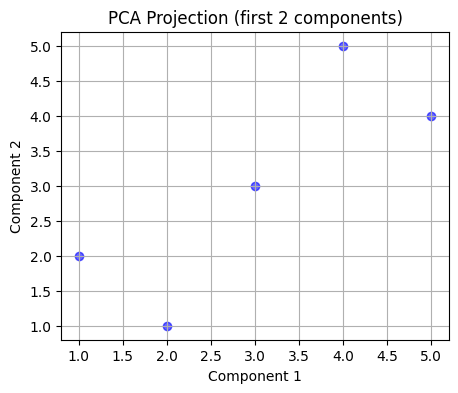

линейные точки: тест пройден


In [183]:
import matplotlib as plt

def test_plot_pca_projection_show():
    # пример проекции (n x 2)
    X_proj = Matrix([[1, 2], [2, 1], [3, 3], [4, 5], [5, 4]])
    fig = plot_pca_projection(X_proj)

    # отобража график прямо в ноутбуке
    ax = fig.axes[0]
    fig.set_size_inches(5, 4)  # размер графика
    plt.figure(figsize=(5, 4))
    plt.title(ax.get_title())
    plt.xlabel(ax.get_xlabel())
    plt.ylabel(ax.get_ylabel())
    plt.grid(True)

    # Получаем точки из scatter и рисуем
    paths = ax.collections[0].get_offsets()
    xs, ys = zip(*paths)
    plt.scatter(xs, ys, color='blue', alpha=0.6)

    plt.show()

test_plot_pca_projection_show()

def test_plot_linear_points():
    X_proj = Matrix([[i, i] for i in range(5)])  # Диагональ
    fig = plot_pca_projection(X_proj)
    ax = fig.axes[0]
    points = ax.collections[0].get_offsets()
    assert all(abs(x - y) < 1e-8 for x, y in points), "Все точки должны лежать на диагонали"
    print("линейные точки: тест пройден")

test_plot_linear_points()

In [197]:
def test_handle_missing_values():
    X = Matrix([
        [1.0, 2.0, None],
        [2.0, None, 3.0],
        [None, 4.0, 6.0]
    ])

    # Средние по столбцам:
    # col 0: (1+2)/2 = 1.5
    # col 1: (2+4)/2 = 3.0
    # col 2: (3+6)/2 = 4.5

    X_filled = handle_missing_values(X)
    print(X_filled)
test_handle_missing_values()

1.0	2.0	4.5
2.0	3.0	3.0
1.5	4.0	6.0


In [200]:
def test_auto_select_k():
    # Пример: 4 собственных значения, 95% порог
    eigenvalues = [4.0, 2.0, 1.0, 0.5]
    threshold = 0.95  # Нужно покрыть 95% дисперсии

    # Сумма всех = 7.5, 95% от неё ≈ 7.125
    # 4.0 + 2.0 + 1.0 = 7.0 (93.3%)
    # 4.0 + 2.0 + 1.0 + 0.5 = 7.5 (100%) → k = 4
    k = auto_select_k(eigenvalues, threshold)
    
    print(k)
    
test_auto_select_k()

4


In [206]:
def test_gauss_solver():
    print("\nтестирование метода Гаусса...")
    A = Matrix([[2, 1], [1, 2]])
    b = Matrix([[4], [5]])
    solution = gauss_solver(A, b)[0]
    expected = Matrix([[1.0], [2.0]])
    assert solution.data == expected.data, "неправильное решение СЛАУ"
    print("тест пройден")

def test_center_data():
    print("\nтестирование центрирования данных...")
    X = Matrix([[1, 2], [3, 4]])
    X_centered = center_data(X)
    expected = Matrix([[-1, -1], [1, 1]])
    assert X_centered.data == expected.data, "центрирование выполнено неверно"
    print("тест пройден")

def test_covariance_matrix():
    print("\nтестирование ковариационной матрицы...")
    X = Matrix([[1, 2], [3, 4]])
    cov = covariance_matrix(center_data(X))
    expected = Matrix([[2.0, 2.0], [2.0, 2.0]])
    assert cov.data == expected.data, "неверный расчет ковариации"
    print("тест пройден")

def test_explained_variance_ratio():
    print("\nтестирование объясненной дисперсии...")
    eigenvalues = [4.0, 2.0, 1.0]
    ratio = explained_variance_ratio(eigenvalues, k=2)
    assert abs(ratio - 0.857) < 0.01, "неправильный расчет доли дисперсии"
    print("тест пройден")

def test_handle_missing_values():
    print("\nтестирование обработки пропусков...")
    X = Matrix([[1.0, None], [None, 4.0], [3.0, 6.0]])
    processed = handle_missing_values(X)
    expected = Matrix([[1.0, 5.0], [2.0, 4.0], [3.0, 6.0]])
    assert processed.data == expected.data, "пропуски заполнены неверно"
    print("тест пройден")

def test_auto_select_k():
    print("\nтестирование автоматического выбора k...")
    eigenvalues = [4.0, 2.0, 1.0, 0.5]
    k = auto_select_k(eigenvalues, threshold=0.95)
    assert k == 4, "неверный выбор числа компонент"
    print("тест пройден")

def test_pca_projection():
    print("\nтестирование проекции PCA...")
    X = Matrix([[2, 1], [1, 2]])
    proj, _ = pca(X, k=1)
    assert proj.shape() == (2,1), "неверная размерность проекции"
    print("тест пройден")

def test_all_functions():
    test_gauss_solver()
    test_center_data()
    test_covariance_matrix()
    test_explained_variance_ratio()
    test_handle_missing_values()
    test_auto_select_k()
    test_pca_projection()
    print("\nвсе основные тесты пройдены!")

test_all_functions()


тестирование метода Гаусса...
тест пройден

тестирование центрирования данных...
тест пройден

тестирование ковариационной матрицы...
тест пройден

тестирование объясненной дисперсии...
тест пройден

тестирование обработки пропусков...
тест пройден

тестирование автоматического выбора k...
тест пройден

тестирование проекции PCA...
тест пройден

все основные тесты пройдены!
